In [1]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.metrics import classification_report
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
import lightgbm
from lightgbm import LGBMModel, LGBMRegressor, LGBMClassifier

pd.set_option('display.max_columns', None)

/Users/ben/Desktop/py_proj/march_mania/venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
%%time
import warnings
warnings.filterwarnings('ignore')

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 15 µs


In [3]:
DATA_PATH = 'MDataFiles_Stage1/'
for filename in os.listdir(DATA_PATH):
    print(filename)

MNCAATourneyDetailedResults.csv
MNCAATourneyCompactResults.csv
MSeasons.csv
MRegularSeasonDetailedResults.csv
MNCAATourneySlots.csv
MGameCities.csv
MConferenceTourneyGames.csv
Cities.csv
MRegularSeasonCompactResults.csv
MNCAATourneySeedRoundSlots.csv
MSampleSubmissionStage1.csv
MTeamConferences.csv
MTeamCoaches.csv
MMasseyOrdinals.csv
Conferences.csv
MTeams.csv
MNCAATourneySeeds.csv
MSecondaryTourneyTeams.csv
MTeamSpellings.csv
MSecondaryTourneyCompactResults.csv


## 1. EDA

### 1.1 Seeds

In [4]:
%%time
df_seeds = pd.read_csv(DATA_PATH + 'MNCAATourneySeeds.csv')
df_seeds.head()

CPU times: user 2.11 ms, sys: 1.08 ms, total: 3.19 ms
Wall time: 2.67 ms


,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


### 1.2 Season Results

In [5]:
%%time
df_season_results = pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv")
df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

CPU times: user 88.5 ms, sys: 16.2 ms, total: 105 ms
Wall time: 118 ms


In [6]:
df_season_results['ScoreMargin'] = df_season_results['WScore'] - df_season_results['LScore']

In [7]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreMargin
0,2003,10,1104,68,1328,62,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,6


In [8]:
# Wins, Losses, ScoreMarginWin, ScoreMarginLoss
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"}).fillna(0)

In [9]:
num_win.head()

,Season,TeamID,NumWins
0,2003,1102,12
1,2003,1103,13
2,2003,1104,17
3,2003,1105,7
4,2003,1106,13


In [10]:
num_win.isna().sum()

Season     0
TeamID     0
NumWins    0
dtype: int64

In [11]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"}).fillna(0)

In [12]:
num_loss.head()

,Season,TeamID,NumLosses
0,2003,1102,16
1,2003,1103,14
2,2003,1104,11
3,2003,1105,19
4,2003,1106,15


In [13]:
win_score_margin = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
win_score_margin = win_score_margin[['Season', 'WTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgWinningScoreMargin", "WTeamID": "TeamID"}).fillna(0)

In [14]:
win_score_margin.head()

,Season,TeamID,AvgWinningScoreMargin
0,2003,1102,15.583333
1,2003,1103,9.384615
2,2003,1104,13.176471
3,2003,1105,13.000000
4,2003,1106,10.384615


In [15]:
lose_score_margin = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
lose_score_margin = lose_score_margin[['Season', 'LTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgLosingScoreMargin", "LTeamID": "TeamID"}).fillna(0)

In [16]:
lose_score_margin.head()

,Season,TeamID,AvgLosingScoreMargin
0,2003,1102,11.250000
1,2003,1103,7.500000
2,2003,1104,9.454545
3,2003,1105,11.473684
4,2003,1106,9.266667


In [17]:
# merge
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [18]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [19]:
df_features_season

,Season,TeamID
0,2003,1102
1,2003,1103
2,2003,1104
3,2003,1105
4,2003,1106
...,...,...
6887,2022,1468
6888,2022,1469
6889,2022,1470
6890,2022,1471


In [20]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(win_score_margin, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(lose_score_margin, on=['Season', 'TeamID'], how='left')

In [21]:
df_features_season

,Season,TeamID,NumWins,NumLosses,AvgWinningScoreMargin,AvgLosingScoreMargin
0,2003,1102,12.0,16.0,15.583333,11.250000
1,2003,1103,13.0,14.0,9.384615,7.500000
2,2003,1104,17.0,11.0,13.176471,9.454545
3,2003,1105,7.0,19.0,13.000000,11.473684
4,2003,1106,13.0,15.0,10.384615,9.266667
...,...,...,...,...,...,...
6887,2022,1468,9.0,11.0,10.666667,16.545455
6888,2022,1469,7.0,12.0,11.428571,19.333333
6889,2022,1470,8.0,13.0,11.125000,11.769231
6890,2022,1471,8.0,12.0,10.125000,13.416667


In [22]:
df_features_season['NumWins'] = df_features_season['NumWins'].fillna(0)
df_features_season['NumLosses'] = df_features_season['NumLosses'].fillna(0)
df_features_season['AvgWinningScoreMargin'] = df_features_season['AvgWinningScoreMargin'].fillna(0)
df_features_season['AvgLosingScoreMargin'] = df_features_season['AvgLosingScoreMargin'].fillna(0)

In [23]:
df_features_season

,Season,TeamID,NumWins,NumLosses,AvgWinningScoreMargin,AvgLosingScoreMargin
0,2003,1102,12.0,16.0,15.583333,11.250000
1,2003,1103,13.0,14.0,9.384615,7.500000
2,2003,1104,17.0,11.0,13.176471,9.454545
3,2003,1105,7.0,19.0,13.000000,11.473684
4,2003,1106,13.0,15.0,10.384615,9.266667
...,...,...,...,...,...,...
6887,2022,1468,9.0,11.0,10.666667,16.545455
6888,2022,1469,7.0,12.0,11.428571,19.333333
6889,2022,1470,8.0,13.0,11.125000,11.769231
6890,2022,1471,8.0,12.0,10.125000,13.416667


In [24]:
df_features_season['WinPercentage'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['AvgScoringMargin'] = (
    (df_features_season['NumWins'] * df_features_season['AvgWinningScoreMargin'] - 
    df_features_season['NumLosses'] * df_features_season['AvgLosingScoreMargin'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [25]:
df_features_season

,Season,TeamID,NumWins,NumLosses,AvgWinningScoreMargin,AvgLosingScoreMargin,WinPercentage,AvgScoringMargin
0,2003,1102,12.0,16.0,15.583333,11.250000,0.428571,0.250000
1,2003,1103,13.0,14.0,9.384615,7.500000,0.481481,0.629630
2,2003,1104,17.0,11.0,13.176471,9.454545,0.607143,4.285714
3,2003,1105,7.0,19.0,13.000000,11.473684,0.269231,-4.884615
4,2003,1106,13.0,15.0,10.384615,9.266667,0.464286,-0.142857
...,...,...,...,...,...,...,...,...
6887,2022,1468,9.0,11.0,10.666667,16.545455,0.450000,-4.300000
6888,2022,1469,7.0,12.0,11.428571,19.333333,0.368421,-8.000000
6889,2022,1470,8.0,13.0,11.125000,11.769231,0.380952,-3.047619
6890,2022,1471,8.0,12.0,10.125000,13.416667,0.400000,-4.000000


In [26]:
df_features_season.drop(['AvgWinningScoreMargin', 'AvgLosingScoreMargin'], axis=1, inplace=True)

In [27]:
df_features_season.isna().sum()

Season              0
TeamID              0
NumWins             0
NumLosses           0
WinPercentage       0
AvgScoringMargin    0
dtype: int64

In [28]:
df_features_season

,Season,TeamID,NumWins,NumLosses,WinPercentage,AvgScoringMargin
0,2003,1102,12.0,16.0,0.428571,0.250000
1,2003,1103,13.0,14.0,0.481481,0.629630
2,2003,1104,17.0,11.0,0.607143,4.285714
3,2003,1105,7.0,19.0,0.269231,-4.884615
4,2003,1106,13.0,15.0,0.464286,-0.142857
...,...,...,...,...,...,...
6887,2022,1468,9.0,11.0,0.450000,-4.300000
6888,2022,1469,7.0,12.0,0.368421,-8.000000
6889,2022,1470,8.0,13.0,0.380952,-3.047619
6890,2022,1471,8.0,12.0,0.400000,-4.000000


In [29]:
# tourney results
df_tourney_results = pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv")
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [30]:
df_tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1985,136,1116,63,1234,54
1,1985,136,1120,59,1345,58
2,1985,136,1207,68,1250,43
3,1985,136,1229,58,1425,55
4,1985,136,1242,49,1325,38


In [31]:
# computer ratings
df_massey = pd.read_csv(DATA_PATH + "MMasseyOrdinals.csv")
df_massey = df_massey[df_massey['RankingDayNum'] == 133].drop('RankingDayNum', axis=1).reset_index(drop=True) # use first day of the tournament

In [32]:
df_massey

,Season,SystemName,TeamID,OrdinalRank
0,2003,AP,1112,2
1,2003,AP,1163,23
2,2003,AP,1166,15
3,2003,AP,1173,16
4,2003,AP,1181,7
...,...,...,...,...
309504,2021,WOB,1467,233
309505,2021,WOB,1468,176
309506,2021,WOB,1469,290
309507,2021,WOB,1470,256


In [33]:
systems = []
for year in range(2003, 2019):
    r = df_massey[df_massey['Season'] == year]
    systems.append(r['SystemName'].unique())
    
all_systems = list(set(list(np.concatenate(systems))))

In [34]:
common_systems = []  
for system in all_systems:
    common = True
    for system_years in systems:
        if system not in system_years:
            common = False
    if common:
        common_systems.append(system)
        
common_systems

['RTH', 'RPI', 'DOL', 'WOL', 'USA', 'COL', 'AP', 'SAG', 'MOR', 'WLK', 'POM']

## 2. Feature Engineering

In [35]:
df = df_tourney_results.copy()
df = df[df['Season'] >= 2003].reset_index(drop=True)
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


### 2.1 Seeds

In [36]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [37]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [38]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2003,134,1421,92,1411,84,X16b,X16a
1,2003,136,1112,80,1436,51,Z01,Z16
2,2003,136,1113,84,1272,71,Z10,Z07
3,2003,136,1141,79,1166,73,Z11,Z06
4,2003,136,1143,76,1301,74,W08,W09


In [39]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [40]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [41]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2003,134,1421,92,1411,84,16,16
1,2003,136,1112,80,1436,51,1,16
2,2003,136,1113,84,1272,71,10,7
3,2003,136,1141,79,1166,73,11,6
4,2003,136,1143,76,1301,74,8,9


### 2.2 Season Stats

In [42]:
# WinRatioW is the winning percentage of the winning team during the season
# WinRatioL is the winning percentage of the losing team during the season

df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginW',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginW',
    'WinPercentage': 'WinPercentageW',
    'AvgScoringMargin': 'AvgScoringMarginW',
}).drop(columns='TeamID', axis=1)

In [43]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,NumWinsW,NumLossesW,WinPercentageW,AvgScoringMarginW
0,2003,134,1421,92,1411,84,16,16,13.0,16.0,0.448276,-7.241379
1,2003,136,1112,80,1436,51,1,16,25.0,3.0,0.892857,14.964286
2,2003,136,1113,84,1272,71,10,7,18.0,11.0,0.620690,6.793103
3,2003,136,1141,79,1166,73,11,6,23.0,6.0,0.793103,6.103448
4,2003,136,1143,76,1301,74,8,9,21.0,8.0,0.724138,4.724138


In [44]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginL',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginL',
    'WinPercentage': 'WinPercentageL',
    'AvgScoringMargin': 'AvgScoringMarginL',
}).drop(columns='TeamID', axis=1)

In [45]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,NumWinsW,NumLossesW,WinPercentageW,AvgScoringMarginW,NumWinsL,NumLossesL,WinPercentageL,AvgScoringMarginL
0,2003,134,1421,92,1411,84,16,16,13.0,16.0,0.448276,-7.241379,18.0,12.0,0.600000,1.966667
1,2003,136,1112,80,1436,51,1,16,25.0,3.0,0.892857,14.964286,19.0,10.0,0.655172,4.655172
2,2003,136,1113,84,1272,71,10,7,18.0,11.0,0.620690,6.793103,23.0,6.0,0.793103,8.689655
3,2003,136,1141,79,1166,73,11,6,23.0,6.0,0.793103,6.103448,29.0,4.0,0.878788,14.909091
4,2003,136,1143,76,1301,74,8,9,21.0,8.0,0.724138,4.724138,18.0,12.0,0.600000,4.400000


### 2.3 Computer Ratings

In [46]:
avg_ranking = df_massey.groupby(['Season', 'TeamID']).mean().reset_index()

df = pd.merge(
     df,
     avg_ranking,
     how='left',
     left_on=['Season', 'WTeamID'],
     right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankW'})

df = pd.merge(
    df, 
    avg_ranking, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankL'})

In [47]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,NumWinsW,NumLossesW,WinPercentageW,AvgScoringMarginW,NumWinsL,NumLossesL,WinPercentageL,AvgScoringMarginL,ComputerRankW,ComputerRankL
0,2003,134,1421,92,1411,84,16,16,13.0,16.0,0.448276,-7.241379,18.0,12.0,0.600000,1.966667,240.343750,239.281250
1,2003,136,1112,80,1436,51,1,16,25.0,3.0,0.892857,14.964286,19.0,10.0,0.655172,4.655172,2.676471,153.125000
2,2003,136,1113,84,1272,71,10,7,18.0,11.0,0.620690,6.793103,23.0,6.0,0.793103,8.689655,36.000000,21.705882
3,2003,136,1141,79,1166,73,11,6,23.0,6.0,0.793103,6.103448,29.0,4.0,0.878788,14.909091,45.687500,20.735294
4,2003,136,1143,76,1301,74,8,9,21.0,8.0,0.724138,4.724138,18.0,12.0,0.600000,4.400000,36.406250,50.312500


### 2.4 Metric diff

In [48]:
def add_losing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIDA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIDB",
        "LScore": "ScoreB",
        "SeedW": "SeedA", 
        "SeedL": "SeedB",
        'WinPercentageW' : 'WinPercentageA',
        'WinPercentageL' : 'WinPercentageB',
        'AvgScoringMarginW' : 'AvgScoringMarginA',
        'AvgScoringMarginL' : 'AvgScoringMarginB',
        "ComputerRankW": "ComputerRankA",
        "ComputerRankL": "ComputerRankB",
        'EffectiveFGPct': 'EffectiveFGPctA',
         'PtsPerPoss': 'PtsPerPossA',
         'Possessions': 'PossessionsA',
         'AssistRate': 'AssistRateA',
         'OReboundPct': 'OReboundPctA',
         'DReboundPct': 'DReboundPctA',
         'ATORatio':'ATORatioA', 
         'TORate': 'TORateA',
         'BArcPct': 'BArcPctA',
         'FTRate': 'FTRateA',
         'PossessionsL': 'PossessionsB',
         'PtsPerPossL': 'PtsPerPossB',
         'EffectiveFGPctL': 'EffectiveFGPctB',
         'AssistRateL': 'AssistRateB',
         'OReboundPctL': 'OReboundPctB',
         'DReboundPctL': 'DReboundPctB',
         'ATORatioL': 'ATORatioB',
         'TORateL': 'TORateB',
         'BArcPctL': 'BArcPctB',
         'FTRateL': 'FTRateB'
     }
    
    lose_rename = {
        "WTeamID": "TeamIDB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIDA",
        "LScore": "ScoreA",
        "SeedW": "SeedB", 
        "SeedL": "SeedA",
        'WinPercentageW' : 'WinPercentageB',
        'WinPercentageL' : 'WinPercentageA',
        'AvgScoringMarginW' : 'AvgScoringMarginB',
        'AvgScoringMarginL' : 'AvgScoringMarginA',
        "ComputerRankW": "ComputerRankB",
        "ComputerRankL": "ComputerRankA",
        "EffectiveFGPct": "EffectiveFGPctB",
        "EffectiveFGPctL": "EffectiveFGPctA",
        "PtsPerPoss": "PtsPerPossB",
        "PtsPerPossL": "PtsPerPossA",
         'Possessions': 'PossessionsB',
         'AssistRate': 'AssistRateB',
         'OReboundPct': 'OReboundPctB',
         'DReboundPct': 'DReboundPctB',
         'ATORatio':'ATORatioB', 
         'TORate': 'TORateB',
         'BArcPct': 'BArcPctB',
         'FTRate': 'FTRateB',
         'PossessionsL': 'PossessionsA',
         'PtsPerPossL': 'PtsPerPossA',
         'EffectiveFGPctL': 'EffectiveFGPctA',
         'AssistRateL': 'AssistRateA',
         'OReboundPctL': 'OReboundPctA',
         'DReboundPctL': 'DReboundPctA',
         'ATORatioL': 'ATORatioA',
         'TORateL': 'TORateA',
         'BArcPctL': 'BArcPctA',
         'FTRateL': 'FTRateA'
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    merged_df = pd.concat([win_df, lose_df], axis=0, sort=False)
    
    return merged_df

In [49]:
df = add_losing_matches(df)

In [50]:
df.head()

,Season,DayNum,TeamIDA,ScoreA,TeamIDB,ScoreB,SeedA,SeedB,NumWinsW,NumLossesW,WinPercentageA,AvgScoringMarginA,NumWinsL,NumLossesL,WinPercentageB,AvgScoringMarginB,ComputerRankA,ComputerRankB
0,2003,134,1421,92,1411,84,16,16,13.0,16.0,0.448276,-7.241379,18.0,12.0,0.600000,1.966667,240.343750,239.281250
1,2003,136,1112,80,1436,51,1,16,25.0,3.0,0.892857,14.964286,19.0,10.0,0.655172,4.655172,2.676471,153.125000
2,2003,136,1113,84,1272,71,10,7,18.0,11.0,0.620690,6.793103,23.0,6.0,0.793103,8.689655,36.000000,21.705882
3,2003,136,1141,79,1166,73,11,6,23.0,6.0,0.793103,6.103448,29.0,4.0,0.878788,14.909091,45.687500,20.735294
4,2003,136,1143,76,1301,74,8,9,21.0,8.0,0.724138,4.724138,18.0,12.0,0.600000,4.400000,36.406250,50.312500


In [51]:
df['SeedDiff'] = df['SeedA'] - df['SeedB']
df['WinPercentageDiff'] = df['WinPercentageA'] - df['WinPercentageB']
df['AvgScoringMarginDiff'] = df['AvgScoringMarginA'] - df['AvgScoringMarginB']
df['ComputerRankDiff'] = df['ComputerRankA'] - df['ComputerRankB']

In [52]:
df.head()

,Season,DayNum,TeamIDA,ScoreA,TeamIDB,ScoreB,SeedA,SeedB,NumWinsW,NumLossesW,WinPercentageA,AvgScoringMarginA,NumWinsL,NumLossesL,WinPercentageB,AvgScoringMarginB,ComputerRankA,ComputerRankB,SeedDiff,WinPercentageDiff,AvgScoringMarginDiff,ComputerRankDiff
0,2003,134,1421,92,1411,84,16,16,13.0,16.0,0.448276,-7.241379,18.0,12.0,0.600000,1.966667,240.343750,239.281250,0,-0.151724,-9.208046,1.062500
1,2003,136,1112,80,1436,51,1,16,25.0,3.0,0.892857,14.964286,19.0,10.0,0.655172,4.655172,2.676471,153.125000,-15,0.237685,10.309113,-150.448529
2,2003,136,1113,84,1272,71,10,7,18.0,11.0,0.620690,6.793103,23.0,6.0,0.793103,8.689655,36.000000,21.705882,3,-0.172414,-1.896552,14.294118
3,2003,136,1141,79,1166,73,11,6,23.0,6.0,0.793103,6.103448,29.0,4.0,0.878788,14.909091,45.687500,20.735294,5,-0.085684,-8.805643,24.952206
4,2003,136,1143,76,1301,74,8,9,21.0,8.0,0.724138,4.724138,18.0,12.0,0.600000,4.400000,36.406250,50.312500,-1,0.124138,0.324138,-13.906250


### 2.5 Test Data

In [53]:
df_test = pd.read_csv(DATA_PATH + "MSampleSubmissionStage1.csv")
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIDA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIDB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [54]:
df_test

,ID,Pred,Season,TeamIDA,TeamIDB
0,2016_1112_1114,0.5,2016,1112,1114
1,2016_1112_1122,0.5,2016,1112,1122
2,2016_1112_1124,0.5,2016,1112,1124
3,2016_1112_1138,0.5,2016,1112,1138
4,2016_1112_1139,0.5,2016,1112,1139
...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457
11386,2021_1452_1458,0.5,2021,1452,1458
11387,2021_1455_1457,0.5,2021,1455,1457
11388,2021_1455_1458,0.5,2021,1455,1458


In [55]:
# seeds
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIDA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})

df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIDB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})

df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

In [56]:
df_test

,ID,Pred,Season,TeamIDA,TeamIDB,SeedA,SeedB
0,2016_1112_1114,0.5,2016,1112,1114,6,12
1,2016_1112_1122,0.5,2016,1112,1122,6,16
2,2016_1112_1124,0.5,2016,1112,1124,6,5
3,2016_1112_1138,0.5,2016,1112,1138,6,14
4,2016_1112_1139,0.5,2016,1112,1139,6,9
...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,3,12
11386,2021_1452_1458,0.5,2021,1452,1458,3,9
11387,2021_1455_1457,0.5,2021,1455,1457,11,12
11388,2021_1455_1458,0.5,2021,1455,1458,11,9


In [57]:
# Season Stats
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIDA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginA',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginA',
    'WinPercentage': 'WinPercentageA',
    'AvgScoringMargin': 'AvgScoringMarginA',
    'EffectiveFGPct': 'EffectiveFGPctA',
    'PtsPerPoss': 'PtsPerPossA',
    'Possessions': 'PossessionsA',
    'AssistRate': 'AssistRateA',
    'OReboundPct': 'OReboundPctA',
    'DReboundPct': 'DReboundPctA',
    'ATORatio':'ATORatioA', 
    'TORate': 'TORateA',
    'BArcPct': 'BArcPctA',
    'FTRate': 'FTRateA'
}).drop(columns='TeamID', axis=1)

df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIDB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginB',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginB',
    'WinPercentage': 'WinPercentageB',
    'AvgScoringMargin': 'AvgScoringMarginB',
    'PossessionsL': 'PossessionsB',
    'PtsPerPossL': 'PtsPerPossB',
    'EffectiveFGPctL': 'EffectiveFGPctB',
    'AssistRateL': 'AssistRateB',
    'OReboundPctL': 'OReboundPctB',
    'DReboundPctL': 'DReboundPctB',
    'ATORatioL': 'ATORatioB',
    'TORateL': 'TORateB',
    'BArcPctL': 'BArcPctB',
    'FTRateL': 'FTRateB'
    
}).drop(columns='TeamID', axis=1)

In [58]:
df_test

,ID,Pred,Season,TeamIDA,TeamIDB,SeedA,SeedB,NumWinsA,NumLossesA,WinPercentageA,AvgScoringMarginA,NumWinsB,NumLossesB,WinPercentageB,AvgScoringMarginB
0,2016_1112_1114,0.5,2016,1112,1114,6,12,25.0,8.0,0.757576,12.212121,27.0,4.0,0.870968,9.935484
1,2016_1112_1122,0.5,2016,1112,1122,6,16,25.0,8.0,0.757576,12.212121,16.0,17.0,0.484848,-2.363636
2,2016_1112_1124,0.5,2016,1112,1124,6,5,25.0,8.0,0.757576,12.212121,21.0,11.0,0.656250,6.687500
3,2016_1112_1138,0.5,2016,1112,1138,6,14,25.0,8.0,0.757576,12.212121,19.0,14.0,0.575758,0.666667
4,2016_1112_1139,0.5,2016,1112,1139,6,9,25.0,8.0,0.757576,12.212121,21.0,10.0,0.677419,9.419355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,3,12,18.0,9.0,0.666667,5.185185,23.0,1.0,0.958333,12.750000
11386,2021_1452_1458,0.5,2021,1452,1458,3,9,18.0,9.0,0.666667,5.185185,17.0,12.0,0.586207,5.310345
11387,2021_1455_1457,0.5,2021,1455,1457,11,12,14.0,5.0,0.736842,2.631579,23.0,1.0,0.958333,12.750000
11388,2021_1455_1458,0.5,2021,1455,1458,11,9,14.0,5.0,0.736842,2.631579,17.0,12.0,0.586207,5.310345


In [59]:
### Computer Ratings
df_test = pd.merge(
    df_test,
    avg_ranking,
    how='left',
    left_on=['Season', 'TeamIDA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankA'})

df_test = pd.merge(
    df_test,
    avg_ranking,
    how='left',
    left_on=['Season', 'TeamIDB'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankB'})

In [60]:
df_test

,ID,Pred,Season,TeamIDA,TeamIDB,SeedA,SeedB,NumWinsA,NumLossesA,WinPercentageA,AvgScoringMarginA,NumWinsB,NumLossesB,WinPercentageB,AvgScoringMarginB,ComputerRankA,ComputerRankB
0,2016_1112_1114,0.5,2016,1112,1114,6,12,25.0,8.0,0.757576,12.212121,27.0,4.0,0.870968,9.935484,16.870968,55.457627
1,2016_1112_1122,0.5,2016,1112,1122,6,16,25.0,8.0,0.757576,12.212121,16.0,17.0,0.484848,-2.363636,16.870968,208.293103
2,2016_1112_1124,0.5,2016,1112,1124,6,5,25.0,8.0,0.757576,12.212121,21.0,11.0,0.656250,6.687500,16.870968,24.229508
3,2016_1112_1138,0.5,2016,1112,1138,6,14,25.0,8.0,0.757576,12.212121,19.0,14.0,0.575758,0.666667,16.870968,122.465517
4,2016_1112_1139,0.5,2016,1112,1139,6,9,25.0,8.0,0.757576,12.212121,21.0,10.0,0.677419,9.419355,16.870968,34.241379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,3,12,18.0,9.0,0.666667,5.185185,23.0,1.0,0.958333,12.750000,20.222222,66.711538
11386,2021_1452_1458,0.5,2021,1452,1458,3,9,18.0,9.0,0.666667,5.185185,17.0,12.0,0.586207,5.310345,20.222222,27.961538
11387,2021_1455_1457,0.5,2021,1455,1457,11,12,14.0,5.0,0.736842,2.631579,23.0,1.0,0.958333,12.750000,57.307692,66.711538
11388,2021_1455_1458,0.5,2021,1455,1458,11,9,14.0,5.0,0.736842,2.631579,17.0,12.0,0.586207,5.310345,57.307692,27.961538


In [61]:
## Differences
df_test['SeedDiff'] = df_test['SeedA'] - df_test['SeedB']
df_test['WinPercentageDiff'] = df_test['WinPercentageA'] - df_test['WinPercentageB']
df_test['AvgScoringMarginDiff'] = df_test['AvgScoringMarginA'] - df_test['AvgScoringMarginB']
df_test['ComputerRankDiff'] = df_test['ComputerRankA'] - df_test['ComputerRankB']

In [62]:
df_test

,ID,Pred,Season,TeamIDA,TeamIDB,SeedA,SeedB,NumWinsA,NumLossesA,WinPercentageA,AvgScoringMarginA,NumWinsB,NumLossesB,WinPercentageB,AvgScoringMarginB,ComputerRankA,ComputerRankB,SeedDiff,WinPercentageDiff,AvgScoringMarginDiff,ComputerRankDiff
0,2016_1112_1114,0.5,2016,1112,1114,6,12,25.0,8.0,0.757576,12.212121,27.0,4.0,0.870968,9.935484,16.870968,55.457627,-6,-0.113392,2.276637,-38.586659
1,2016_1112_1122,0.5,2016,1112,1122,6,16,25.0,8.0,0.757576,12.212121,16.0,17.0,0.484848,-2.363636,16.870968,208.293103,-10,0.272727,14.575758,-191.422136
2,2016_1112_1124,0.5,2016,1112,1124,6,5,25.0,8.0,0.757576,12.212121,21.0,11.0,0.656250,6.687500,16.870968,24.229508,1,0.101326,5.524621,-7.358540
3,2016_1112_1138,0.5,2016,1112,1138,6,14,25.0,8.0,0.757576,12.212121,19.0,14.0,0.575758,0.666667,16.870968,122.465517,-8,0.181818,11.545455,-105.594549
4,2016_1112_1139,0.5,2016,1112,1139,6,9,25.0,8.0,0.757576,12.212121,21.0,10.0,0.677419,9.419355,16.870968,34.241379,-3,0.080156,2.792766,-17.370412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,3,12,18.0,9.0,0.666667,5.185185,23.0,1.0,0.958333,12.750000,20.222222,66.711538,-9,-0.291667,-7.564815,-46.489316
11386,2021_1452_1458,0.5,2021,1452,1458,3,9,18.0,9.0,0.666667,5.185185,17.0,12.0,0.586207,5.310345,20.222222,27.961538,-6,0.080460,-0.125160,-7.739316
11387,2021_1455_1457,0.5,2021,1455,1457,11,12,14.0,5.0,0.736842,2.631579,23.0,1.0,0.958333,12.750000,57.307692,66.711538,-1,-0.221491,-10.118421,-9.403846
11388,2021_1455_1458,0.5,2021,1455,1458,11,9,14.0,5.0,0.736842,2.631579,17.0,12.0,0.586207,5.310345,57.307692,27.961538,2,0.150635,-2.678766,29.346154


In [63]:
df_test = df_test.rename(columns={'EffectiveFGPct': 'EffectiveFGPctA',
                                 'PtsPerPoss': 'PtsPerPossA',
                                 'Possessions': 'PossessionsA',
                                 'AssistRate': 'AssistRateA',
                                 'OReboundPct': 'OReboundPctA',
                                 'DReboundPct': 'DReboundPctA',
                                 'ATORatio':'ATORatioA', 
                                 'TORate': 'TORateA',
                                 'BArcPct': 'BArcPctA',
                                 'FTRate': 'FTRateA',
                                 'PossessionsL': 'PossessionsB',
                                 'PtsPerPossL': 'PtsPerPossB',
                                 'EffectiveFGPctL': 'EffectiveFGPctB',
                                 'AssistRateL': 'AssistRateB',
                                 'OReboundPctL': 'OReboundPctB',
                                 'DReboundPctL': 'DReboundPctB',
                                 'ATORateL': 'ATORatioB',
                                 'TORateL': 'TORateB',
                                 'BArcPctL': 'BArcPctB',
                                 'FTRateL': 'FTRateB'})

In [64]:
df_test

,ID,Pred,Season,TeamIDA,TeamIDB,SeedA,SeedB,NumWinsA,NumLossesA,WinPercentageA,AvgScoringMarginA,NumWinsB,NumLossesB,WinPercentageB,AvgScoringMarginB,ComputerRankA,ComputerRankB,SeedDiff,WinPercentageDiff,AvgScoringMarginDiff,ComputerRankDiff
0,2016_1112_1114,0.5,2016,1112,1114,6,12,25.0,8.0,0.757576,12.212121,27.0,4.0,0.870968,9.935484,16.870968,55.457627,-6,-0.113392,2.276637,-38.586659
1,2016_1112_1122,0.5,2016,1112,1122,6,16,25.0,8.0,0.757576,12.212121,16.0,17.0,0.484848,-2.363636,16.870968,208.293103,-10,0.272727,14.575758,-191.422136
2,2016_1112_1124,0.5,2016,1112,1124,6,5,25.0,8.0,0.757576,12.212121,21.0,11.0,0.656250,6.687500,16.870968,24.229508,1,0.101326,5.524621,-7.358540
3,2016_1112_1138,0.5,2016,1112,1138,6,14,25.0,8.0,0.757576,12.212121,19.0,14.0,0.575758,0.666667,16.870968,122.465517,-8,0.181818,11.545455,-105.594549
4,2016_1112_1139,0.5,2016,1112,1139,6,9,25.0,8.0,0.757576,12.212121,21.0,10.0,0.677419,9.419355,16.870968,34.241379,-3,0.080156,2.792766,-17.370412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,3,12,18.0,9.0,0.666667,5.185185,23.0,1.0,0.958333,12.750000,20.222222,66.711538,-9,-0.291667,-7.564815,-46.489316
11386,2021_1452_1458,0.5,2021,1452,1458,3,9,18.0,9.0,0.666667,5.185185,17.0,12.0,0.586207,5.310345,20.222222,27.961538,-6,0.080460,-0.125160,-7.739316
11387,2021_1455_1457,0.5,2021,1455,1457,11,12,14.0,5.0,0.736842,2.631579,23.0,1.0,0.958333,12.750000,57.307692,66.711538,-1,-0.221491,-10.118421,-9.403846
11388,2021_1455_1458,0.5,2021,1455,1458,11,9,14.0,5.0,0.736842,2.631579,17.0,12.0,0.586207,5.310345,57.307692,27.961538,2,0.150635,-2.678766,29.346154


In [65]:
## Target Variable
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

## 3. Modeling

### 3.1 Scalling

In [66]:
features = [
    "SeedA", 
    "SeedB",
    'WinPercentageA',
    'WinPercentageB',
    'AvgScoringMarginA',
    'AvgScoringMarginB',
    "ComputerRankA",
    "ComputerRankB"
]

target = ['WinA']


In [67]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

In [68]:
def standard_scale(features, df_train, df_val, df_test=None):
    pt = PowerTransformer(method='yeo-johnson')
    df_train[features] = pt.fit_transform(df_train[features])
    df_val[features] = pt.transform(df_val[features])
    
    if df_test is not None:
        df_test[features] = pt.transform(df_test[features])
    
    return df_train, df_val, df_test

In [69]:
df_test

,ID,Pred,Season,TeamIDA,TeamIDB,SeedA,SeedB,NumWinsA,NumLossesA,WinPercentageA,AvgScoringMarginA,NumWinsB,NumLossesB,WinPercentageB,AvgScoringMarginB,ComputerRankA,ComputerRankB,SeedDiff,WinPercentageDiff,AvgScoringMarginDiff,ComputerRankDiff
0,2016_1112_1114,0.5,2016,1112,1114,6,12,25.0,8.0,0.757576,12.212121,27.0,4.0,0.870968,9.935484,16.870968,55.457627,-6,-0.113392,2.276637,-38.586659
1,2016_1112_1122,0.5,2016,1112,1122,6,16,25.0,8.0,0.757576,12.212121,16.0,17.0,0.484848,-2.363636,16.870968,208.293103,-10,0.272727,14.575758,-191.422136
2,2016_1112_1124,0.5,2016,1112,1124,6,5,25.0,8.0,0.757576,12.212121,21.0,11.0,0.656250,6.687500,16.870968,24.229508,1,0.101326,5.524621,-7.358540
3,2016_1112_1138,0.5,2016,1112,1138,6,14,25.0,8.0,0.757576,12.212121,19.0,14.0,0.575758,0.666667,16.870968,122.465517,-8,0.181818,11.545455,-105.594549
4,2016_1112_1139,0.5,2016,1112,1139,6,9,25.0,8.0,0.757576,12.212121,21.0,10.0,0.677419,9.419355,16.870968,34.241379,-3,0.080156,2.792766,-17.370412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,3,12,18.0,9.0,0.666667,5.185185,23.0,1.0,0.958333,12.750000,20.222222,66.711538,-9,-0.291667,-7.564815,-46.489316
11386,2021_1452_1458,0.5,2021,1452,1458,3,9,18.0,9.0,0.666667,5.185185,17.0,12.0,0.586207,5.310345,20.222222,27.961538,-6,0.080460,-0.125160,-7.739316
11387,2021_1455_1457,0.5,2021,1455,1457,11,12,14.0,5.0,0.736842,2.631579,23.0,1.0,0.958333,12.750000,57.307692,66.711538,-1,-0.221491,-10.118421,-9.403846
11388,2021_1455_1458,0.5,2021,1455,1458,11,9,14.0,5.0,0.736842,2.631579,17.0,12.0,0.586207,5.310345,57.307692,27.961538,2,0.150635,-2.678766,29.346154


### 3.2 Modeling

In [70]:
season = 2016
df_train = df[df['Season'] < season].copy()
df_val = df[df['Season'] == season].copy()        
rescaled = rescale(features, df_train, df_val)
X_train = rescaled[0][features]
X_validation = rescaled[1][features]
y_train = df_train['WinA'].values
y_validation = df_val['WinA'].values

In [71]:
lightgbmc_model = LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=42)

### 3.3 Cross Validation

In [72]:
def kfold_reg(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[12:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].copy()
        df_val = df[df['Season'] == season].copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = standard_scale(features, df_train, df_val, df_test)
        
        if mode == "reg":
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = xgb.XGBClassifier()
            # model = LGBMClassifier(**lgbm_params, boosting_type='gbdt', objective='binary', random_state=42)
            
            
        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred)
            plt.show()
        
        loss = log_loss(df_val['WinA'].values, pred)
        cvs.append(loss)

        if verbose:
            print(f'\t -> Scored {loss:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests

## 4. Submission

In [73]:
df_test[features]

,SeedA,SeedB,WinPercentageA,WinPercentageB,AvgScoringMarginA,AvgScoringMarginB,ComputerRankA,ComputerRankB
0,6,12,0.757576,0.870968,12.212121,9.935484,16.870968,55.457627
1,6,16,0.757576,0.484848,12.212121,-2.363636,16.870968,208.293103
2,6,5,0.757576,0.656250,12.212121,6.687500,16.870968,24.229508
3,6,14,0.757576,0.575758,12.212121,0.666667,16.870968,122.465517
4,6,9,0.757576,0.677419,12.212121,9.419355,16.870968,34.241379
...,...,...,...,...,...,...,...,...
11385,3,12,0.666667,0.958333,5.185185,12.750000,20.222222,66.711538
11386,3,9,0.666667,0.586207,5.185185,5.310345,20.222222,27.961538
11387,11,12,0.736842,0.958333,2.631579,12.750000,57.307692,66.711538
11388,11,9,0.736842,0.586207,2.631579,5.310345,57.307692,27.961538



Validating on season 2015
[10:06:02] WARNING: /private/var/folders/kg/_wytrhns3kgck5_ldyyl74xw0000gn/T/pip-install-eap9soue/xgboost_c7d00fe342f64e88af96ab58bd3cab0c/build/temp.macosx-10.9-universal2-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


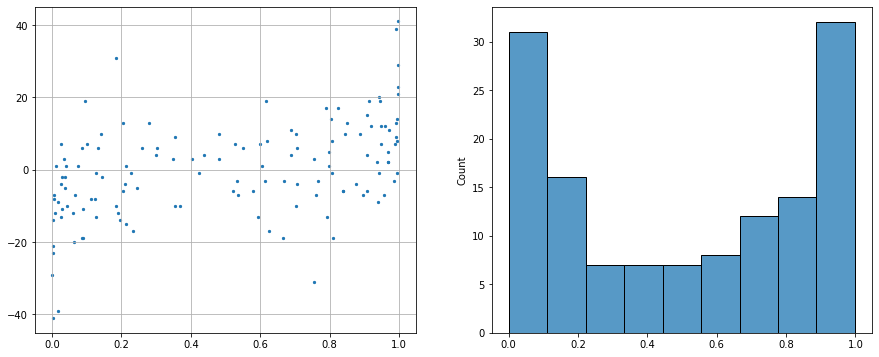

	 -> Scored 0.784

Validating on season 2016
[10:06:02] WARNING: /private/var/folders/kg/_wytrhns3kgck5_ldyyl74xw0000gn/T/pip-install-eap9soue/xgboost_c7d00fe342f64e88af96ab58bd3cab0c/build/temp.macosx-10.9-universal2-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


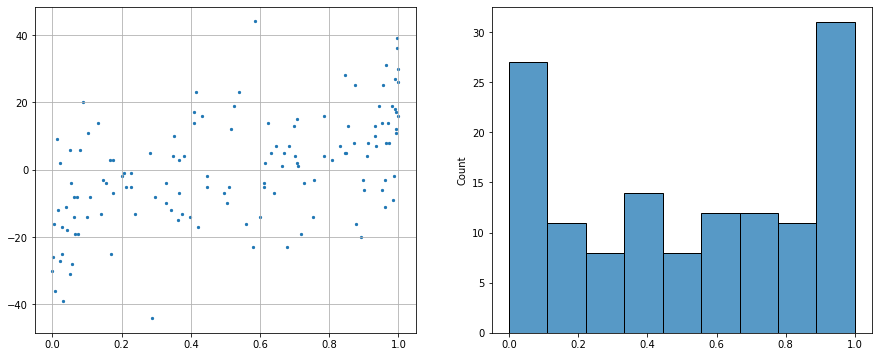

	 -> Scored 0.691

Validating on season 2017
[10:06:02] WARNING: /private/var/folders/kg/_wytrhns3kgck5_ldyyl74xw0000gn/T/pip-install-eap9soue/xgboost_c7d00fe342f64e88af96ab58bd3cab0c/build/temp.macosx-10.9-universal2-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


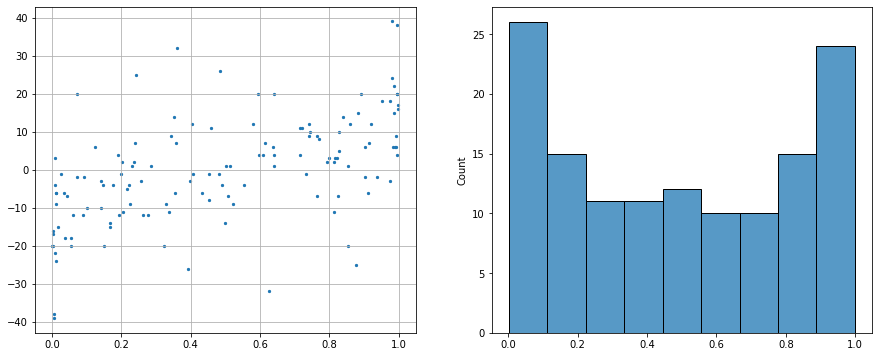

	 -> Scored 0.544

Validating on season 2018
[10:06:02] WARNING: /private/var/folders/kg/_wytrhns3kgck5_ldyyl74xw0000gn/T/pip-install-eap9soue/xgboost_c7d00fe342f64e88af96ab58bd3cab0c/build/temp.macosx-10.9-universal2-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


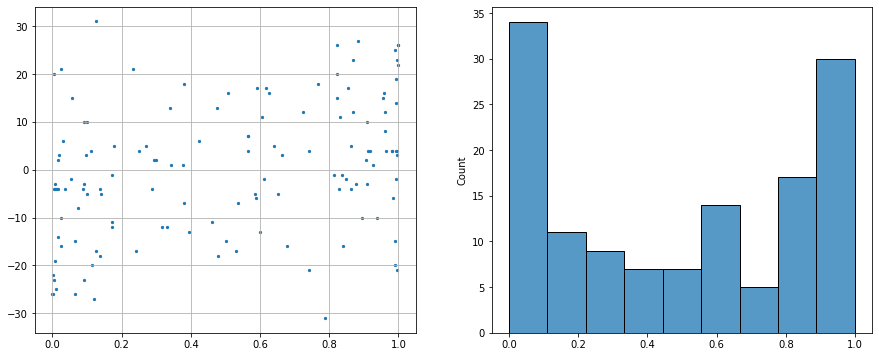

	 -> Scored 0.882

Validating on season 2019
[10:06:03] WARNING: /private/var/folders/kg/_wytrhns3kgck5_ldyyl74xw0000gn/T/pip-install-eap9soue/xgboost_c7d00fe342f64e88af96ab58bd3cab0c/build/temp.macosx-10.9-universal2-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


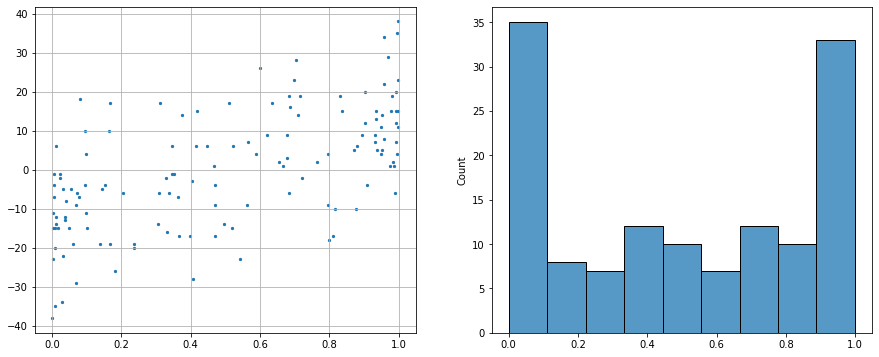

	 -> Scored 0.468

Validating on season 2021
[10:06:03] WARNING: /private/var/folders/kg/_wytrhns3kgck5_ldyyl74xw0000gn/T/pip-install-eap9soue/xgboost_c7d00fe342f64e88af96ab58bd3cab0c/build/temp.macosx-10.9-universal2-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


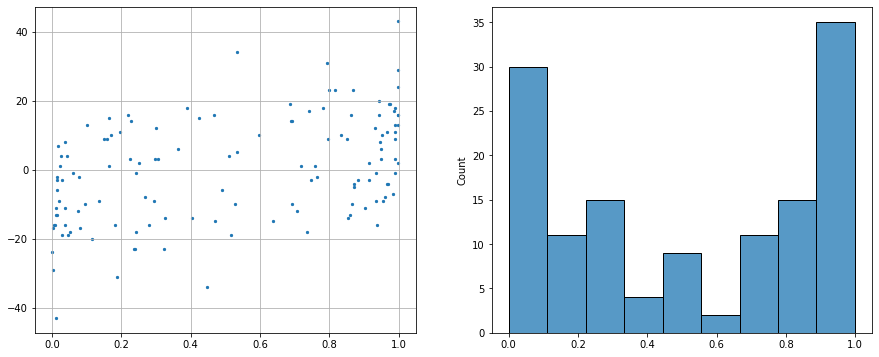

	 -> Scored 0.861

 Local CV is 0.705


In [74]:
pred_tests = kfold_reg(df, df_test[features], plot=True, verbose=1, mode="cls")

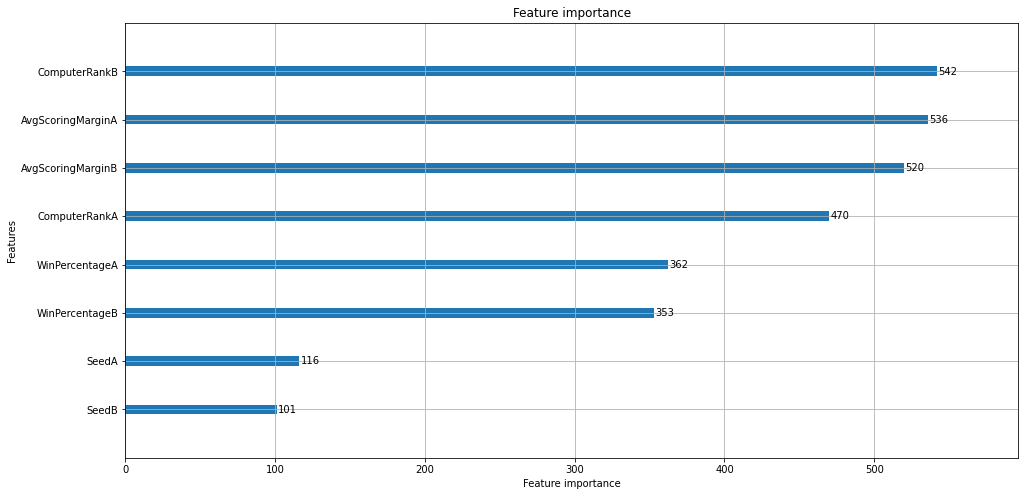

In [75]:
# lightgbm
f, ax = plt.subplots(figsize=(16, 8))
model = LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=42)
model.fit(X_train, y_train)
lightgbm.plot_importance(model, ax=ax)
plt.show()

In [76]:
pred_tests

[array([0.9385347 , 0.99534816, 0.59735006, ..., 0.08439475, 0.0423584 ,
        0.43171597], dtype=float32),
 array([0.8652217 , 0.980956  , 0.6407124 , ..., 0.022191  , 0.04130331,
        0.21279919], dtype=float32),
 array([0.6837506 , 0.992857  , 0.8267653 , ..., 0.05764372, 0.06547851,
        0.29783642], dtype=float32),
 array([0.4759237 , 0.9586554 , 0.48587582, ..., 0.12192611, 0.05223563,
        0.13499206], dtype=float32),
 array([0.5052799 , 0.97832257, 0.74209595, ..., 0.19182321, 0.03970798,
        0.11861372], dtype=float32),
 array([0.6374083 , 0.9959401 , 0.7785711 , ..., 0.08259925, 0.0338742 ,
        0.104156  ], dtype=float32)]

In [77]:
pred_test = np.mean(pred_tests, 0)
sub = df_test[['ID', 'Pred']].copy()
sub['Pred'] = pred_test
sub.to_csv('submission_0313.csv', index=False)

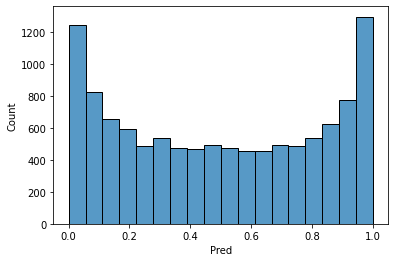

In [78]:
_ = sns.histplot(sub['Pred'])